```
conda install -c conda-forge scikit-learn pandas
```

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

### Primera actividad de redes neuronales

In [4]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X_data = cancer.data
y_data = cancer.target

(https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer)
- En el siguiente bloque explore la data, con el fin de responder a estas preguntas.

	I) ¿De que se trata el dataset?

	II) ¿Cuales son las clases de salida?

	III) ¿A que corresponden las caracteristicas?

	IV) ¿Cuantas caracteristicas y clases de salida hay?
	
	V) Etc.

**I)**  Las características se calculan a partir de una imagen digitalizada de un aspirado con aguja fina (AAF) de una masa mamaria.  Describen las características de los núcleos celulares presentes en la imagen.

**II)** Las clases de salida son 2: B (cáncer benigno) y M (cáncer maligno).

**III)** Las características son 30. Aqui van las descripciones de algunas:

	a) radio (media de las distancias del centro a los puntos del perímetro)

	b) textura (desviación típica de los valores de la escala de grises)

	c) perímetro

	d) área

	e) suavidad (variación local de las longitudes de los radios)

	f) compacidad (perímetro^2 / área - 1,0)

	g) concavidad (gravedad de las partes cóncavas del contorno)

	h) puntos cóncavos (número de porciones cóncavas del contorno)

	i) simetría 

	j) dimensión fractal ("aproximación de la línea de costa" - 1)

**IV)** Existen 32 caracteristicas  y dos clases de salida.


In [11]:
import torch
from torch.utils.data import random_split,DataLoader,TensorDataset

X = torch.tensor(X_data, dtype=torch.float32)
Y = torch.tensor(y_data,dtype=torch.long)

dataset = TensorDataset(X,Y)

train_set, valid_set,test_set = random_split(dataset,[342,113,114],generator=torch.Generator().manual_seed(1234)) ##No cambiar la semilla

train_loader = DataLoader(train_set, shuffle=True, batch_size=32)
valid_loader = DataLoader(valid_set, shuffle=False, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

Using device: cpu


## Implentación de la Red Neuronal
- En el siguiente bloque implemente el modelo que utilizará su red neuronal para predecir si un paciente tiene cáncer o no, teniendo en cuenta sus caracteristicas.

In [6]:
import torch.nn as nn
import torch.optim as optim

class BreastCancerNN(nn.Module):
	def __init__(self,input_dim,hidden_dim,output_dim):
		super(BreastCancerNN, self).__init__()
		self.hidden = nn.Linear(input_dim, hidden_dim)
		self.output = nn.Linear(hidden_dim, output_dim)
		self.activation = nn.Sigmoid()
	def forward(self, x):
		x = self.hidden(x)
		x = self.activation(x)
		x = self.output(x)
		return x


- En el siguiente bloque cree una instancia de su red neuronal definida anteriormente y defina una función de pérdida y optimizador adecuados:

In [7]:
model = BreastCancerNN(30,5,2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

- Responda: 
	- ¿Porqué eligió esa función de pérdida?
		- ...
	- Elija 2 optimizadores populares y describalos, luego explique porqué elige uno de los 2.
		- ...   

- En el siguiente bloque programe el entrenamiento de su red neuronal

**I)** Ocupe CrossEntropyLoss ya que compara la distribucion de probabilidad predicha por el modelo con la distribucion real y clasifica instancias en categorias discretas, que es justo lo que necesitamos para este ejemplo, si tiene o no cancer de mama (0 o 1).

**II)**

In [8]:
# Entrenamiento
losses = []
for nepoch in range(25000):
	model.train()
	for batch_x, batch_y in train_loader:
		optimizer.zero_grad()
		hatY = model(batch_x)
		loss = criterion(hatY, batch_y)
		loss.backward()
		optimizer.step()
		losses.append(loss.item())
	if(nepoch % 1000 == 0):
		print(f'Epoch {nepoch} Loss {loss.item()}')

# Evaluación
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
	for batch_x, batch_y in test_loader:
		predicted = model(batch_x)
		all_preds.extend(predicted.numpy())
		all_labels.extend(batch_y.numpy())

Epoch 0 Loss 0.6396100521087646
Epoch 1000 Loss 0.6779136657714844
Epoch 2000 Loss 0.6925753951072693
Epoch 3000 Loss 0.6612464189529419
Epoch 4000 Loss 0.7091651558876038
Epoch 5000 Loss 0.6766377091407776
Epoch 6000 Loss 0.6345727443695068
Epoch 7000 Loss 0.6628275513648987
Epoch 8000 Loss 0.7270711660385132
Epoch 9000 Loss 0.7409959435462952
Epoch 10000 Loss 0.645790159702301
Epoch 11000 Loss 0.6438193917274475
Epoch 12000 Loss 0.7435937523841858
Epoch 13000 Loss 0.6612540483474731
Epoch 14000 Loss 0.6765828728675842
Epoch 15000 Loss 0.6158885955810547
Epoch 16000 Loss 0.7095855474472046
Epoch 17000 Loss 0.6468217968940735
Epoch 18000 Loss 0.6613196730613708
Epoch 19000 Loss 0.7077025771141052
Epoch 20000 Loss 0.7448446750640869
Epoch 21000 Loss 0.725999116897583
Epoch 22000 Loss 0.6143881678581238
Epoch 23000 Loss 0.7100270986557007
Epoch 24000 Loss 0.6929851174354553


- En el sigueinte bloque muestre el gráfico de entrenamiento y validación.
- ¿El entrenamiento de su red neuronal está "listo"?

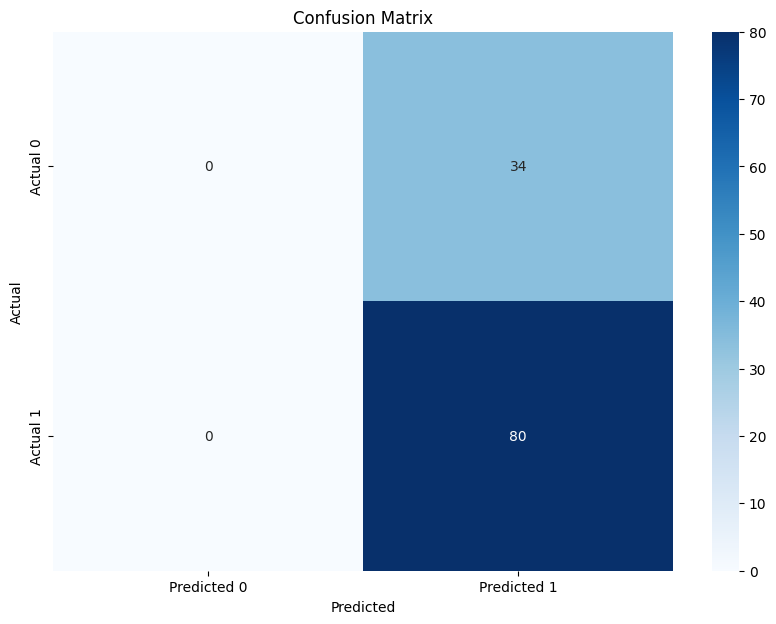

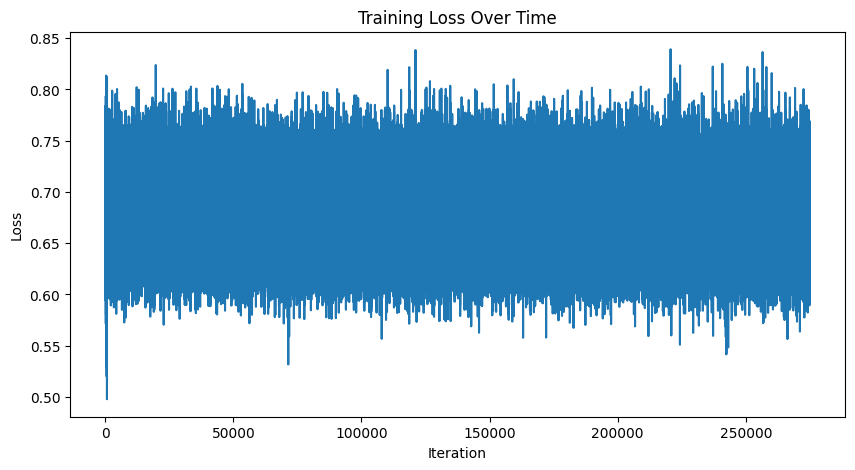

In [9]:
import seaborn as sns

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Generación del heatmap
conf_matrix = np.zeros((2, 2), dtype=int)
for true, pred in zip(all_labels, np.argmax(all_preds, axis=1)):
	conf_matrix[true, pred] += 1

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Gráfico de la pérdida
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

- En el siguiente bloque evalue que tan bueno es su modelo mediante diferentes métricas

In [10]:
# Evaluación
model.eval()
with torch.no_grad():
	predicted = model(X)
	predicted_classes = torch.argmax(predicted, dim=1)
	accuracy = (predicted_classes == Y).sum().item() / len(Y)
	print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 62.92%


- Concluya sobre su trabajo.  
- Responda
	- ¿Qué tan confiable sería su modelo en un entorno clínico? 
	- ¿Qué haría para mejorarlo?
	- Sobre la matriz de confusión, ¿Alguno de sus elementos son más importantes que otros en este caso?
	¿Que significaría el aumento de FN o FP en este caso? 
- Investigue sobre alguna arquitectura de red neuronal distinta a la utilizada en este trabajo, describala y explique en que casos sería útil.



### Pregunta Bonus
- ¿Cúal es la principal limitación de las redes neuronales comparado al cerebro humano?